# 数据集加载

PyG是一个基于PyTorch的且用于处理图中不规则结构数据的深度学习计算框架

除了出类拔萃的运行速度，PyG中还集成了很多论文中提出的方法（GCN、SGC、GAT、SAGE等）和常用基准数据集，这些数据集包括但不限于：

(1)Cora，一个根据科学论文之间相互引用关系而构建的图数据集，论文中的类型分为7类（后面有介绍），共2708篇。

(2)Citeseer，论文之间引用信息的数据集，论文分为Agents、AI、DB、IR、ML和HCI 6类，共包含3312篇。

(3)Pubmed，生物医学方面的论文搜寻及摘要数据集。

In [1]:
import torch
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T

data_name = 'Cora'
path = './data'

dataset = Planetoid(path, data_name, transform=T.NormalizeFeatures())
data = dataset[0]
print("数据集名称:", dataset)
print("子图数量:", len(dataset))
print("特征维度:", dataset.num_features)
print("类别数量:", dataset.num_classes)
print('f'"节点的个数:{data.num_nodes}")
print('f'"边的条数:{data.num_edges}")
print('f'"节点平均度数:{data.num_edges / data.num_nodes:.2f}")

数据集名称: Cora()
子图数量: 1
特征维度: 1433
类别数量: 7
f节点的个数:{data.num_nodes}
f边的条数:{data.num_edges}
f节点平均度数:{data.num_edges / data.num_nodes:.2f}


In [2]:
data.keys()

['test_mask', 'y', 'edge_index', 'x', 'train_mask', 'val_mask']

In [3]:
data.x.shape

torch.Size([2708, 1433])

In [4]:
data.y.shape

torch.Size([2708])

# 构造正负样本

下面我们来构造训练所用的正样本和负样本。

为了简化程序设计复杂度，我们依然采用PyG提供的采样组件。

有所不同的是，这里我们重构了NeighborSampler类的sample方法来创建带有正样本和负样本的批次。

In [5]:
from torch_cluster import random_walk
from torch_geometric.loader import NeighborSampler as Raw
from torch_geometric.nn import SAGEConv
class NeighborSampler(Raw):
    def sample(self, batch):
        # 将batch转换为tensor
        batch = torch.tensor(batch)
        # 获取邻接矩阵的行和列
        row, col, _ = self.adj_t.coo()
        # 进行随机游走，获取正样本
        pos_batch = random_walk(row, col, batch, walk_length=1, coalesced=False)[:, 1]
        # 随机采样负样本
        neg_batch = torch.randint(0, self.adj_t.size(1), (batch.numel(), ), dtype=torch.long)
        # 将正负样本拼接在一起
        batch = torch.cat([batch, pos_batch, neg_batch], dim=0)
        # 调用父类的sample方法，获取邻居采样
        return super(NeighborSampler, self).sample(batch)
    
train_loader = NeighborSampler(data.edge_index, sizes = [10, 10], batch_size = 256, shuffle = True, num_nodes=data.num_nodes)

GraphSAGE的小批量(Minibatch)训练是通过邻居节点采样实现的，这使得大规模全连接图的GNN模型训练成为可能。采样操作是借用PyG的torch_geometric.loader.NeighborSampler实现的（第02行），它实际上属于数据加载器，如同“数据抽水机”，train_loader每次都源源不断地给训练集或测试集输送小批量数据（第15行）。

对于小批量图中的每个节点，NeighborSampler分别抽取一个直接邻居节点作为正例（第07和第08行），一个随机节点作为负例（第09行）。这样的采样操作和原本PyG提供的NeighborSampler操作有所不同，因此我们需要在继承类中改写这个采样方法，并传回父类。

# 定义模型

In [6]:
import torch.nn as nn
#定义SAGE模型
class SAGE(nn.Module):
    #初始化函数，定义模型层
    def __init__(self, in_channels, hidden_channels, num_layers):
        super(SAGE, self).__init__()
        #定义层数
        self.num_layers = num_layers
        #定义模块列表
        self.convs = nn.ModuleList()
        #循环定义每一层
        for i in range(num_layers):
            #如果是第一层，输入通道为输入通道，否则为隐藏通道
            in_channels = in_channels if i == 0 else hidden_channels
            #添加SAGEConv层
            self.convs.append(SAGEConv(in_channels, hidden_channels))
            
    #前向传播函数
    def forward(self, x, adjs):
        #循环每一层
        for i, (edge_index, _, size) in enumerate(adjs):
            #获取目标节点
            x_target = x[:size[1]]
            #每一层的传播
            x = self.convs[i]((x, x_target), edge_index)
            #如果不是最后一层，则进行relu激活函数和dropout
            if i != self.num_layers - 1:
                x = x.relu()
                x = nn.functional.dropout(x, p=0.5, training=self.training)
        #返回最终结果
        return x
                
    #全前向传播函数
    def full_forward(self, x, edge_index):
        #循环每一层
        for i, conv in enumerate(self.convs):
            #每一层的传播
            x = conv(x, edge_index)
            #如果不是最后一层，则进行relu激活函数和dropout
            if i != self.num_layers - 1:
                x = x.relu()
                x = nn.functional.dropout(x, p=0, training=self.training)
        #返回最终结果
        return x

# 训练参数配置

In [7]:
device = None
model = SAGE(data.num_node_features, hidden_channels=64, num_layers=2)
optimer = torch.optim.Adam(model.parameters(), lr=0.01)
x, edge_index = data.x, data.edge_index

# 训练模型模块

In [8]:
from torch.nn import functional as F

def train():
    model.train()
    total_loss = 0
    for batch_size, n_id, adjs in train_loader:
        adjs = [adj for adj in adjs]
        optimer.zero_grad()
        
        out = model(x[n_id], adjs)
        out, pos_out, neg_out = out.split(out.size(0) // 3, dim=0)
        
        pos_loss = F.logsigmoid((out * pos_out).sum(dim=1)).mean()
        neg_loss = F.logsigmoid((-out * neg_out).sum(dim=1)).mean()
        loss = -pos_loss - neg_loss
        
        loss.backward()
        optimer.step()
        
        total_loss += float(loss) * out.size(0)
        
        
    return total_loss / data.num_nodes



# 测试模型模块

In [9]:
from sklearn.linear_model import LogisticRegression

@ torch.no_grad()
def test():
    model.eval()
    out = model.full_forward(x, edge_index)
    clf = LogisticRegression()
    clf.fit(out[data.train_mask], data.y[data.train_mask])
    
    val_acc = clf.score(out[data.val_mask], data.y[data.val_mask])
    test_acc = clf.score(out[data.test_mask], data.y[data.test_mask])
    
    return val_acc, test_acc

# 模型训练流程

In [10]:
for epoch in range(1, 31):
    loss = train()
    val_acc, test_acc = test()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 01, Loss: 1.3861, Val: 0.3240, Test: 0.3440
Epoch: 02, Loss: 1.2905, Val: 0.4640, Test: 0.4610
Epoch: 03, Loss: 1.1746, Val: 0.5640, Test: 0.5490
Epoch: 04, Loss: 1.1154, Val: 0.5980, Test: 0.6050
Epoch: 05, Loss: 1.1029, Val: 0.6760, Test: 0.6600
Epoch: 06, Loss: 1.0769, Val: 0.6840, Test: 0.6680
Epoch: 07, Loss: 1.0536, Val: 0.6880, Test: 0.6980
Epoch: 08, Loss: 1.0355, Val: 0.6980, Test: 0.7000
Epoch: 09, Loss: 1.0246, Val: 0.7140, Test: 0.7180
Epoch: 10, Loss: 1.0072, Val: 0.7140, Test: 0.7320
Epoch: 11, Loss: 0.9955, Val: 0.7240, Test: 0.7450
Epoch: 12, Loss: 0.9861, Val: 0.7400, Test: 0.7490
Epoch: 13, Loss: 0.9688, Val: 0.7400, Test: 0.7390
Epoch: 14, Loss: 0.9541, Val: 0.7400, Test: 0.7550
Epoch: 15, Loss: 0.9622, Val: 0.7280, Test: 0.7430
Epoch: 16, Loss: 0.9677, Val: 0.7300, Test: 0.7410
Epoch: 17, Loss: 0.9504, Val: 0.7340, Test: 0.7450
Epoch: 18, Loss: 0.9354, Val: 0.7320, Test: 0.7540
Epoch: 19, Loss: 0.9259, Val: 0.7340, Test: 0.7470
Epoch: 20, Loss: 0.9556, Val: 0

# 嵌入表示可视化

In [11]:
with torch.no_grad():
    model.eval()
    out = model.full_forward(x, edge_index)
out.shape

torch.Size([2708, 64])

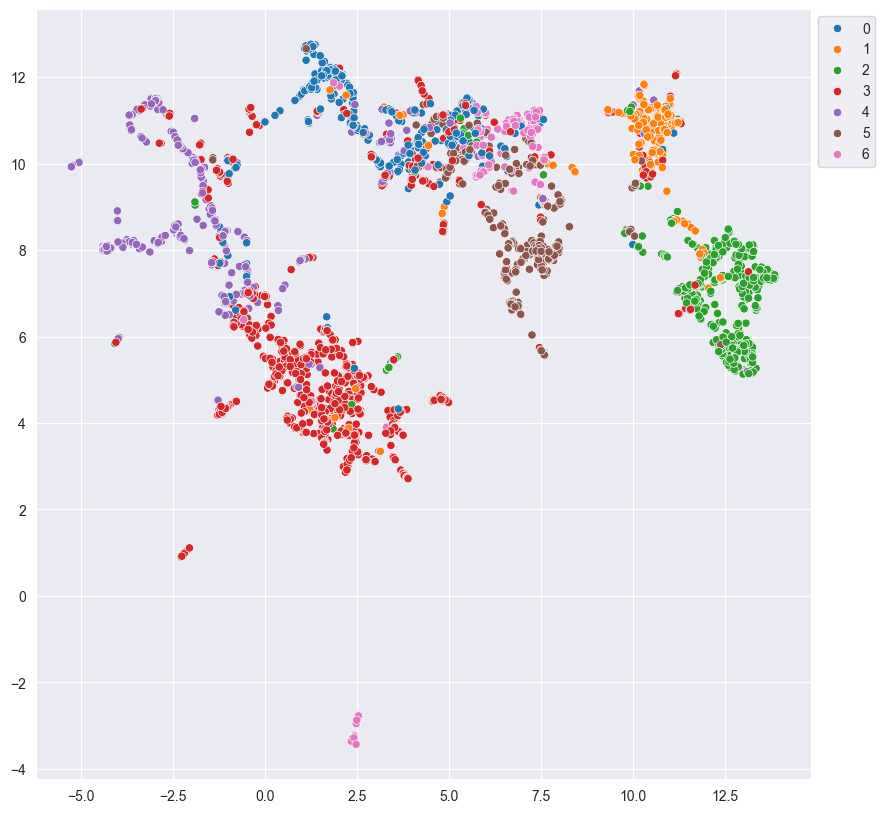

In [12]:
from umap import UMAP
import matplotlib.pyplot as plt
import seaborn as sns

palette = {}
for n, y in enumerate(set(data.y.numpy())):
    palette[y] = f'C{n}'

embd = UMAP().fit_transform(out.numpy())
plt.figure(figsize=(10, 10))
sns.scatterplot(x=embd.T[0], y=embd.T[1], hue=data.y.numpy(), palette=palette)
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.show()

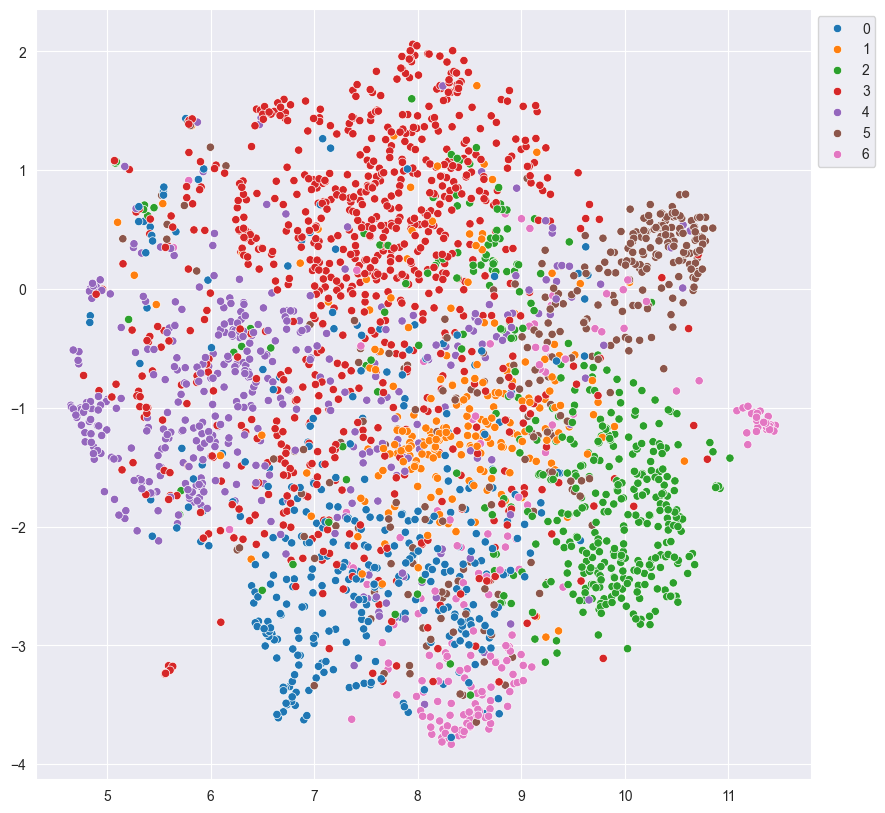

In [13]:
embd_x = UMAP().fit_transform(data.x.numpy())
plt.figure(figsize=(10, 10))
sns.scatterplot(x=embd_x.T[0], y=embd_x.T[1], hue=data.y.numpy(), palette=palette)
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.show()